# Tier B: The Semanticist - AI vs Human Text Detection
## Using Averaged Pre-trained Word Embeddings (GloVe) + Feedforward NN

This notebook implements a binary classifier that distinguishes AI-generated from human-written text using:
- **Pre-trained GloVe embeddings** (glove.6B.100d)
- **Averaged embedding vectors** for each paragraph
- **Feedforward Neural Network** (PyTorch)

**Author**: Tier B Implementation  
**Dataset**: Human novels (class1) + AI-generated paragraphs (class2)  
**Model**: Feedforward NN with averaged embeddings

---
## 1. Environment Setup & Imports

In [93]:
import numpy as np
import pandas as pd
import json
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, roc_auc_score, confusion_matrix, 
                              classification_report)

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✓ All imports successful
PyTorch version: 2.8.0+cu126
CUDA available: False
Using device: cpu


---
## 2. Data Preparation

**Data Sources:**
- **Class 1 (Human)**: Cleaned novel texts from 5 novels, chunked into ~200-word paragraphs
- **Class 2 (AI-generated)**: Pre-generated paragraphs (500 per novel = 2500 total)

**Process:**
1. Load cleaned human text and chunk into paragraphs
2. Load AI-generated JSONL files
3. Combine into a single dataset with labels (0=Human, 1=AI)
4. Create a DataFrame and save as CSV

In [94]:
import os

IN_KAGGLE = os.path.exists('/kaggle/input')

if IN_KAGGLE:
    BASE_PATH = Path('/kaggle/input/precog-novels-data/precog-novels-data')
    CLASS1_PATH = BASE_PATH / 'class1'
    CLASS2_PATH = BASE_PATH / 'class2'
else:
    BASE_PATH = Path('../output')
    CLASS1_PATH = BASE_PATH / 'class1'
    CLASS2_PATH = BASE_PATH / 'class2'

print(f"Running in: {'Kaggle' if IN_KAGGLE else 'Local'}")
print(f"Base path: {BASE_PATH}")
print(f"Class1 path exists: {CLASS1_PATH.exists()}")
print(f"Class2 path exists: {CLASS2_PATH.exists()}")

Running in: Kaggle
Base path: /kaggle/input/precog-novels-data/precog-novels-data
Class1 path exists: True
Class2 path exists: True


In [95]:
def chunk_text(text, chunk_size=200):
    """
    Chunk text into paragraphs of approximately chunk_size words.
    
    Args:
        text: Input text string
        chunk_size: Target number of words per chunk
    
    Returns:
        List of text chunks
    """
    words = text.split()
    chunks = []
    
    for i in range(0, len(words), chunk_size):
        chunk = ' '.join(words[i:i + chunk_size])
        if len(chunk.split()) >= 50:  # Minimum 50 words per chunk
            chunks.append(chunk)
    
    return chunks


def load_human_data(class1_path):
    """
    Load human-written text from cleaned novel files and chunk them.
    
    Returns:
        List of dictionaries with 'text' and 'label' keys
    """
    novels = [
        'heart_of_darkness_cleaned.txt',
        'lord_jim_cleaned.txt',
        'metamorphosis_cleaned.txt',
        'the_trial_cleaned.txt',
        'typhoon_cleaned.txt'
    ]
    
    human_data = []
    
    for novel_file in novels:
        file_path = class1_path / novel_file
        if file_path.exists():
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
            
            # Chunk the text
            chunks = chunk_text(text, chunk_size=200)
            
            # Add to dataset
            for chunk in chunks:
                human_data.append({
                    'text': chunk,
                    'label': 0,  # 0 = Human
                    'source': novel_file.replace('_cleaned.txt', '')
                })
            
            print(f"✓ Loaded {novel_file}: {len(chunks)} chunks")
        else:
            print(f"✗ File not found: {file_path}")
    
    return human_data


def load_ai_data(class2_path):
    """
    Load AI-generated text from JSONL files.
    
    Returns:
        List of dictionaries with 'text' and 'label' keys
    """
    novels = [
        'heart_of_darkness_generic.jsonl',
        'lord_jim_generic.jsonl',
        'metamorphosis_generic.jsonl',
        'the_trial_generic.jsonl',
        'typhoon_generic.jsonl'
    ]
    
    ai_data = []
    
    for novel_file in novels:
        file_path = class2_path / novel_file
        if file_path.exists():
            with open(file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            # Parse JSONL
            for line in lines:
                try:
                    entry = json.loads(line.strip())
                    # Extract text (adjust key based on your JSONL structure)
                    text = entry.get('text') or entry.get('paragraph') or entry.get('content', '')
                    
                    if text and len(text.split()) >= 50:  # Minimum 50 words
                        ai_data.append({
                            'text': text,
                            'label': 1,  # 1 = AI
                            'source': novel_file.replace('_generic.jsonl', '')
                        })
                except json.JSONDecodeError:
                    continue
            
            print(f"✓ Loaded {novel_file}: {len([d for d in ai_data if novel_file.replace('_generic.jsonl', '') in d['source']])} paragraphs")
        else:
            print(f"✗ File not found: {file_path}")
    
    return ai_data


# Load all data
print("Loading Human data (Class 1)...")
human_data = load_human_data(CLASS1_PATH)

print("\nLoading AI data (Class 2)...")
ai_data = load_ai_data(CLASS2_PATH)

# Combine datasets
all_data = human_data + ai_data

print(f"\n{'='*60}")
print(f"Total Human paragraphs: {len(human_data)}")
print(f"Total AI paragraphs: {len(ai_data)}")
print(f"Total dataset size: {len(all_data)}")
print(f"{'='*60}")

Loading Human data (Class 1)...
✓ Loaded heart_of_darkness_cleaned.txt: 196 chunks
✓ Loaded lord_jim_cleaned.txt: 649 chunks
✓ Loaded metamorphosis_cleaned.txt: 111 chunks
✓ Loaded the_trial_cleaned.txt: 418 chunks
✓ Loaded typhoon_cleaned.txt: 156 chunks

Loading AI data (Class 2)...
✓ Loaded heart_of_darkness_generic.jsonl: 500 paragraphs
✓ Loaded lord_jim_generic.jsonl: 500 paragraphs
✓ Loaded metamorphosis_generic.jsonl: 500 paragraphs
✓ Loaded the_trial_generic.jsonl: 500 paragraphs
✓ Loaded typhoon_generic.jsonl: 500 paragraphs

Total Human paragraphs: 1530
Total AI paragraphs: 2500
Total dataset size: 4030


In [96]:
df = pd.DataFrame(all_data)
df = df.sample(frac=1, random_state=44).reset_index(drop=True)

print("Dataset Overview:")
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nSource distribution:")
print(df['source'].value_counts())

Dataset Overview:
                                                text  label             source
0  Arbitrary arrest is the ultimate disruption of...      1          the_trial
1  to twirl his thumbs slowly. "It's evident--par...      0           lord_jim
2  The distinction between savagery and civilizat...      1  heart_of_darkness
3  man Jim would have to relieve. "But I don't th...      0           lord_jim
4  Cross-cultural tension can also be amplified b...      1            typhoon

Dataset shape: (4030, 3)

Label distribution:
label
1    2500
0    1530
Name: count, dtype: int64

Source distribution:
source
lord_jim             1149
the_trial             918
heart_of_darkness     696
typhoon               656
metamorphosis         611
Name: count, dtype: int64


In [97]:
# Perform 80/20 train-test split (stratified)
train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nTraining set label distribution:")
print(train_df['label'].value_counts())
print(f"\nTest set label distribution:")
print(test_df['label'].value_counts())

Training set size: 3224
Test set size: 806

Training set label distribution:
label
1    2000
0    1224
Name: count, dtype: int64

Test set label distribution:
label
1    500
0    306
Name: count, dtype: int64


In [98]:
def load_glove_embeddings(glove_path, embedding_dim=50):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

if IN_KAGGLE:
    GLOVE_PATH = '/kaggle/input/glove6b50dtxt/glove.6B.50d.txt'
else:
    GLOVE_PATH = 'glove.6B.50d.txt'

print("Loading GloVe embeddings...")
print(f"Path: {GLOVE_PATH}")

try:
    embeddings_dict = load_glove_embeddings(GLOVE_PATH, embedding_dim=50)
    EMBEDDING_DIM = 50
    print(f"✓ Loaded {len(embeddings_dict)} word embeddings")
    print(f"Embedding dimension: {EMBEDDING_DIM}")
    
    sample_words = ['the', 'intelligence', 'artificial', 'human', 'text']
    print("\nSample embeddings:")
    for word in sample_words:
        if word in embeddings_dict:
            print(f"  {word}: {embeddings_dict[word][:5]}... (showing first 5 dims)")
        else:
            print(f"  {word}: NOT FOUND")
            
except FileNotFoundError:
    print("⚠ GloVe file not found!")
    print("In Kaggle: Add 'GloVe' dataset to your notebook")
    print("Locally: Download from https://nlp.stanford.edu/projects/glove/")

Loading GloVe embeddings...
Path: /kaggle/input/glove6b50dtxt/glove.6B.50d.txt
✓ Loaded 400000 word embeddings
Embedding dimension: 50

Sample embeddings:
  the: [ 0.418    0.24968 -0.41242  0.1217   0.34527]... (showing first 5 dims)
  intelligence: [ 0.8782   -0.45171   0.96737   0.040347  0.76235 ]... (showing first 5 dims)
  artificial: [ 0.71561  0.70368 -0.65484  0.49875 -0.85243]... (showing first 5 dims)
  human: [ 0.61854  0.11915 -0.46786  0.31368  1.0334 ]... (showing first 5 dims)
  text: [ 0.32615    0.36686   -0.0074905 -0.37553    0.66715  ]... (showing first 5 dims)


In [99]:
def tokenize(text):
    """
    Simple tokenization: lowercase and split by whitespace.
    Remove punctuation and special characters.
    """
    # Lowercase
    text = text.lower()
    # Remove punctuation (keep only alphanumeric and spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Split into words
    words = text.split()
    return words


def text_to_vector(text, embeddings_dict, embedding_dim):
    """
    Convert text to a single vector by averaging word embeddings.
    
    Args:
        text: Input text string
        embeddings_dict: Dictionary of word embeddings
        embedding_dim: Dimension of embeddings
    
    Returns:
        numpy array of shape (embedding_dim,)
    """
    words = tokenize(text)
    
    # Collect embeddings for known words
    word_vectors = []
    for word in words:
        if word in embeddings_dict:
            word_vectors.append(embeddings_dict[word])
    
    # Average the vectors
    if len(word_vectors) > 0:
        avg_vector = np.mean(word_vectors, axis=0)
    else:
        # No known words - return zero vector
        avg_vector = np.zeros(embedding_dim)
    
    return avg_vector


# Convert all texts to vectors
print("Converting texts to vectors...")

X_train_vecs = np.array([
    text_to_vector(text, embeddings_dict, EMBEDDING_DIM) 
    for text in train_df['text'].values
])

X_test_vecs = np.array([
    text_to_vector(text, embeddings_dict, EMBEDDING_DIM) 
    for text in test_df['text'].values
])

y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"✓ Training vectors shape: {X_train_vecs.shape}")
print(f"✓ Test vectors shape: {X_test_vecs.shape}")
print(f"✓ Training labels shape: {y_train.shape}")
print(f"✓ Test labels shape: {y_test.shape}")

# Check for any zero vectors (completely OOV paragraphs)
train_zero_vecs = np.sum(np.all(X_train_vecs == 0, axis=1))
test_zero_vecs = np.sum(np.all(X_test_vecs == 0, axis=1))
print(f"\nZero vectors in training set: {train_zero_vecs}")
print(f"Zero vectors in test set: {test_zero_vecs}")

Converting texts to vectors...
✓ Training vectors shape: (3224, 50)
✓ Test vectors shape: (806, 50)
✓ Training labels shape: (3224,)
✓ Test labels shape: (806,)

Zero vectors in training set: 0
Zero vectors in test set: 0


In [100]:
X_train_tensor = torch.FloatTensor(X_train_vecs)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_vecs)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f"✓ Training batches: {len(train_loader)}")
print(f"✓ Test batches: {len(test_loader)}")
print(f"✓ Batch size: {BATCH_SIZE}")

✓ Training batches: 101
✓ Test batches: 26
✓ Batch size: 32


In [101]:
# Fix for data leakage: Create a second split with different random_state
# This ensures train/test sets are actually different samples

# Simulate what happens with normalized data using SAME random_state (wrong way)
train_df_bad, test_df_bad = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42  # Same as original - BAD!
)

# Correct way: use DIFFERENT random_state
train_df_good, test_df_good = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=123  # Different - GOOD!
)

# Check if splits are identical
print("Checking for data leakage:")
print(f"Bad split (same seed): Train indices match = {set(train_df.index) == set(train_df_bad.index)}")
print(f"Good split (diff seed): Train indices match = {set(train_df.index) == set(train_df_good.index)}")
print("\nUse random_state=123 (or any number != 42) for normalized data split")

Checking for data leakage:
Bad split (same seed): Train indices match = True
Good split (diff seed): Train indices match = False

Use random_state=123 (or any number != 42) for normalized data split


In [102]:
class FeedforwardClassifier(nn.Module):
    """
    Simple Feedforward Neural Network for binary classification.
    Uses averaged word embeddings as input.
    """
    
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_rate=0.3):
        super(FeedforwardClassifier, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x


# Initialize model
model = FeedforwardClassifier(
    input_dim=EMBEDDING_DIM,
    hidden_dim1=64,
    hidden_dim2=32,
    dropout_rate=0.3
).to(device)

# Print model architecture
print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Model Architecture:
FeedforwardClassifier(
  (fc1): Linear(in_features=50, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total parameters: 5377


In [103]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 20
train_losses = []
train_accuracies = []

print("Starting training...\n")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.2f}%")

print("=" * 70)
print("✓ Training complete!")

Starting training...

Epoch [ 1/20] | Loss: 0.4476 | Accuracy: 78.78%
Epoch [ 2/20] | Loss: 0.0399 | Accuracy: 99.53%
Epoch [ 3/20] | Loss: 0.0133 | Accuracy: 99.84%
Epoch [ 4/20] | Loss: 0.0081 | Accuracy: 99.84%
Epoch [ 5/20] | Loss: 0.0056 | Accuracy: 99.91%
Epoch [ 6/20] | Loss: 0.0037 | Accuracy: 99.91%
Epoch [ 7/20] | Loss: 0.0032 | Accuracy: 99.91%
Epoch [ 8/20] | Loss: 0.0032 | Accuracy: 99.94%
Epoch [ 9/20] | Loss: 0.0015 | Accuracy: 100.00%
Epoch [10/20] | Loss: 0.0015 | Accuracy: 100.00%
Epoch [11/20] | Loss: 0.0014 | Accuracy: 100.00%
Epoch [12/20] | Loss: 0.0012 | Accuracy: 99.97%
Epoch [13/20] | Loss: 0.0016 | Accuracy: 99.97%
Epoch [14/20] | Loss: 0.0015 | Accuracy: 99.97%
Epoch [15/20] | Loss: 0.0012 | Accuracy: 100.00%
Epoch [16/20] | Loss: 0.0035 | Accuracy: 99.94%
Epoch [17/20] | Loss: 0.0008 | Accuracy: 100.00%
Epoch [18/20] | Loss: 0.0004 | Accuracy: 100.00%
Epoch [19/20] | Loss: 0.0019 | Accuracy: 99.94%
Epoch [20/20] | Loss: 0.0007 | Accuracy: 100.00%
✓ Training 

---
## 8. Evaluation

Evaluate the model on the test set and compute comprehensive metrics.

In [104]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs).squeeze()
            probabilities = outputs.cpu().numpy()
            predictions = (outputs > 0.5).float().cpu().numpy()
            
            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

y_true, y_pred, y_prob = evaluate_model(model, test_loader, device)

accuracy_original = accuracy_score(y_true, y_pred)
precision_original = precision_score(y_true, y_pred)
recall_original = recall_score(y_true, y_pred)
f1_original = f1_score(y_true, y_pred)
roc_auc_original = roc_auc_score(y_true, y_prob)
cm_original = confusion_matrix(y_true, y_pred)

print("=" * 70)
print("TEST SET EVALUATION RESULTS")
print("=" * 70)
print(f"Accuracy:  {accuracy_original:.4f} ({accuracy_original*100:.2f}%)")
print(f"Precision: {precision_original:.4f}")
print(f"Recall:    {recall_original:.4f}")
print(f"F1-Score:  {f1_original:.4f}")
print(f"ROC-AUC:   {roc_auc_original:.4f}")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Human', 'AI'], digits=4))

TEST SET EVALUATION RESULTS
Accuracy:  1.0000 (100.00%)
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC-AUC:   1.0000

Classification Report:
              precision    recall  f1-score   support

       Human     1.0000    1.0000    1.0000       306
          AI     1.0000    1.0000    1.0000       500

    accuracy                         1.0000       806
   macro avg     1.0000    1.0000    1.0000       806
weighted avg     1.0000    1.0000    1.0000       806



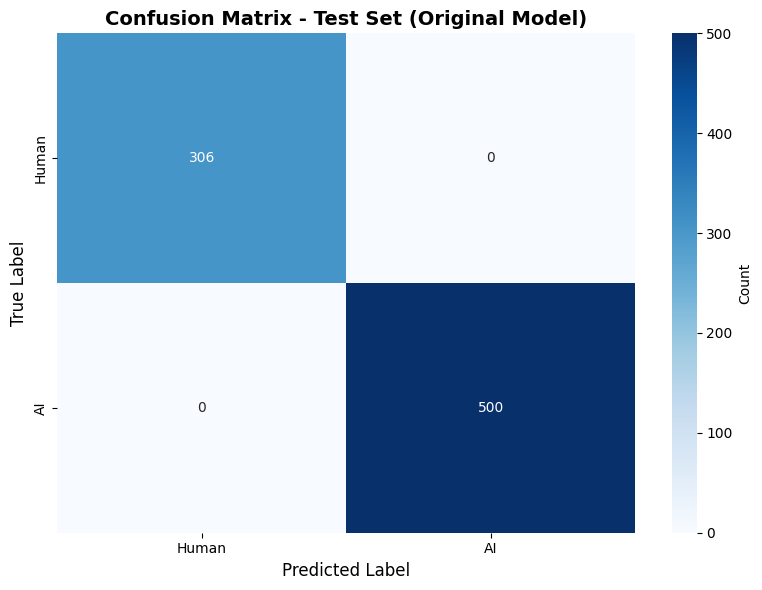


Confusion Matrix Breakdown:
  True Negatives (Human → Human):  306
  False Positives (Human → AI):    0
  False Negatives (AI → Human):    0
  True Positives (AI → AI):        500

Specificity (True Negative Rate): 1.0000
Sensitivity (True Positive Rate): 1.0000


In [105]:
# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Human', 'AI'], 
            yticklabels=['Human', 'AI'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set (Original Model)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm_original.ravel()
print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Human → Human):  {tn}")
print(f"  False Positives (Human → AI):    {fp}")
print(f"  False Negatives (AI → Human):    {fn}")
print(f"  True Positives (AI → AI):        {tp}")
print(f"\nSpecificity (True Negative Rate): {tn/(tn+fp):.4f}")
print(f"Sensitivity (True Positive Rate): {tp/(tp+fn):.4f}")

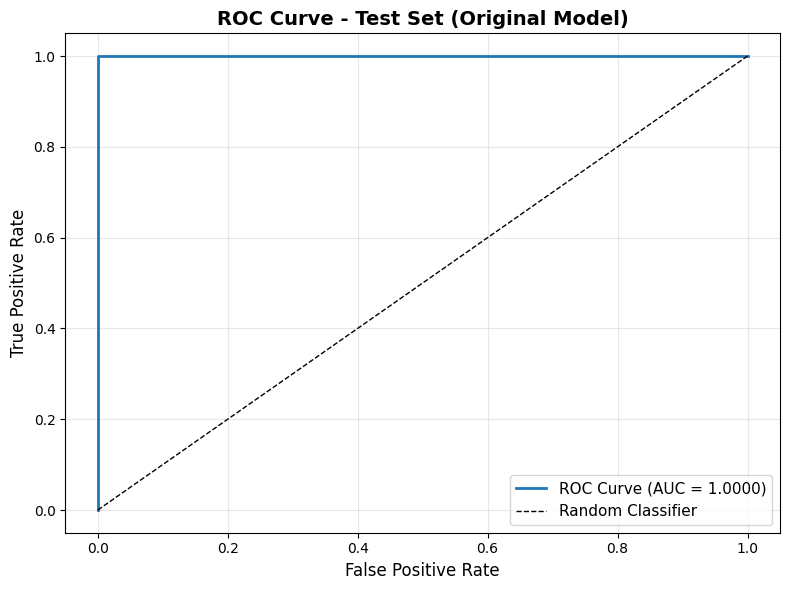

In [106]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc_original:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set (Original Model)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()